<a href="https://colab.research.google.com/github/majavier26/DSProjects/blob/main/Term%20deposit%20prediction%20/Term_deposit_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! pip install shap
! pip install xgboost
! pip install lightgbm

In [52]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.colors as cm

# Modelling
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,  AdaBoostClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import lightgbm as lgb

# Data balancing
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE, SMOTEN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, NearMiss, AllKNN, EditedNearestNeighbours, RepeatedEditedNearestNeighbours
from imblearn.combine import SMOTETomek, SMOTEENN

# Interpretation
import shap

# Miscellaneous
import time

In [4]:
from google.colab import drive, files
drive.mount('/content/drive')

Mounted at /content/drive


## Term deposit prediction

[This dataset](https://archive.ics.uci.edu/dataset/222/bank+marketing) comes from UC Irvine Machine Learning Repository and it involves classifying if a client will avail a term deposit from a handful of input variables. We have 16 input variables:
- age (numeric)
- job (categorical)
- marital status (categorical)
- education (categorical)
- default history (binary)
- average yearly balance (binary)
- existence of housing loan (binary)
- contact communication type (categorical)
- last contact day of the month (numeric)
- last contact month of the year (categorical)
- last contact duration (numeric)
- number of contacts performed (numeric)
- days that passed after client was last contacted in this campaign (numeric)
- previous number of contacts before this campaign
- outcome of previous marketing campaign

and one output variable: whether a client has availed a term deposit.

### Exploratory data analysis

#### Preliminary checking
Let's import the dataset.

In [5]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Term deposit availing prediction/Data/bank-full.csv', sep=';')
data

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


Although the website says that there are no null values, let's still check it for good measure.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


Now let's see the relevant statistical metrics for this dataset. We already know that the dataset contains 4521 rows and it indeed does, shown in the `count` row.

We also see in the `age column` that the minimum age is 19 years old, barely pass the legal age, and that the maximum age is 87 years old. It must be noted that the opposite sides of the age spectrum is correlated with risky behavior.

We also see the opposite behaviors in the `balance` column where the minimum balance is -€3313 while the maximum balance is +€4521.

In [7]:
data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


### Observing the data

Now that our data is initialized, we can observe the relationships of the variables with each other. We can closely observe how some variables can correlate with the occurence of clients availing a term deposit. Let's make a function that will plot a distribution of clients if they availed a term deposit or not.

In [8]:
def plot_numgraph(data, var1, var2, title):
  # Uses a DataFrame data to plot a histogram showing the distribution of clients according to string var2 and is segregated via string var1 and entitles it with a string title.
  # Stats
  mean_var, std_var = data[var1].groupby(data[var2]).mean().loc['yes'], data[var1].groupby(data[var2]).std().loc['yes']
  sigma_low, sigma_high = mean_var - std_var, mean_var + std_var

  # Plotting
  sns.histplot(data=data, x=var1, hue=var2, multiple='stack', palette='Set2')
  plt.title(title)
  plt.xticks(rotation=30, fontsize=10)
  plt.axvline(x=mean_var, ymin=0, ymax=470, color='red', linestyle='--')
  plt.fill_between([sigma_low, sigma_high], 0, 500, alpha=0.4, color='gray')
  if data[var1].max() > 10000:
    plt.xlim([sigma_low, 10000])
  # Annotation
  plt.text(x=mean_var, y=450, s=f'Mean {var1}\n{np.round(mean_var, 2)}',
          horizontalalignment='center', verticalalignment='center',
          bbox=dict(facecolor='white', edgecolor='lightgrey', boxstyle='round'))
  plt.text(x=sigma_low, y=450, s=f'{np.round(sigma_low, 2)}',
          horizontalalignment='center', verticalalignment='center',
          bbox=dict(facecolor='white', edgecolor='lightgrey', boxstyle='round', alpha=0.5))
  plt.text(x=sigma_high, y=450, s=f'{np.round(sigma_high, 2)}',
          horizontalalignment='center', verticalalignment='center',
          bbox=dict(facecolor='white', edgecolor='lightgrey', boxstyle='round', alpha=0.5))
  plt.show()
  return None

#### **Age vs. Y**
The distribution is right-skewed as middle-aged people are generally the largest clientele of banks. We can also see a sharp drop in counts when `age > 60` as the retirement age is either 60 or 65 year old.

We can observe that age range is 19-87 and mean age of the people who availed a term deposit is 42.5 with a standard deviation of ~18. Using the 68-95-99 rule, we can say that 65% of the people who availed a term deposit are within ~29 to ~56 years old. This is our target population and we want to capitalize on them, so we must employ techniques that will cater to them.

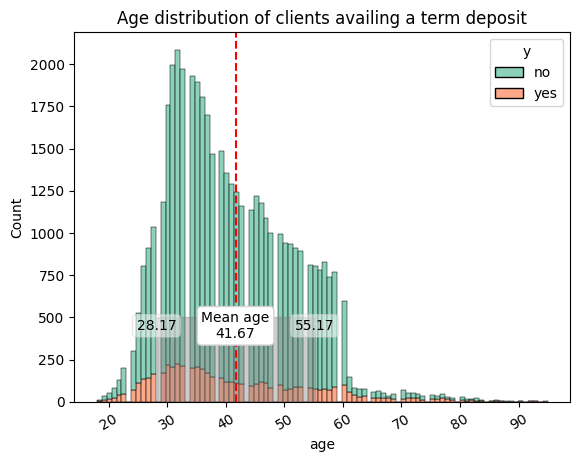

In [9]:
plot_numgraph(data, 'age', 'y', 'Age distribution of clients availing a term deposit')

#### **Balance vs. Y**

Here we see a very skewed distribution, with most of the clients having close to 0 balance by the end of the year. However, we see that the mean balance is €1571 with a 1-sigma range of -€877 and 4016. We see that our target audience are middle class people, preferrably with positive balance.

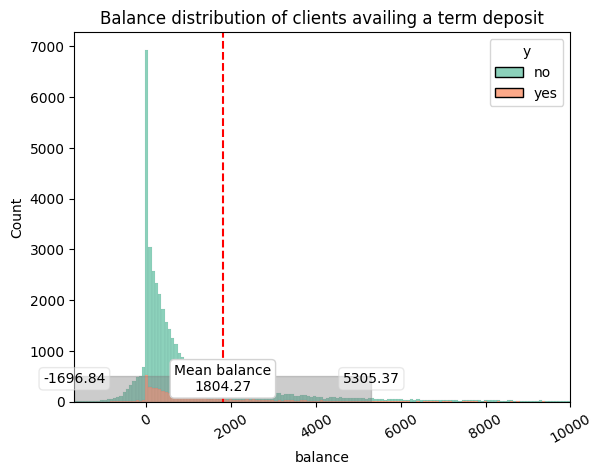

In [10]:
plot_numgraph(data, 'balance', 'y', 'Balance distribution of clients availing a term deposit')

#### **Employment vs. Y**

To see what jobs are more inclined to avail a term deposit, we can do the same thing but with the `job` column. Below we see that the top 5 employment of term deposit-availing clients are:
- management
- self-employed
- blue-collar
- admin.
- retired
This make sense as the pay grade of these people are within or above the average. However, this does not mean that we should only cater our services to them as we figured out previously that we should cater to middle class people.

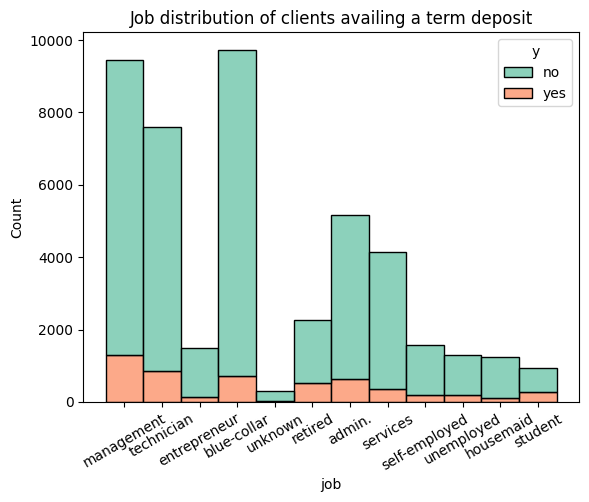

In [11]:
## Plotting
sns.histplot(data=data, x='job', hue='y', multiple='stack', palette='Set2')
plt.title('Job distribution of clients availing a term deposit')
plt.xticks(rotation=30, fontsize=10)
plt.show()

#### Existing loan vs Y

Now, we can observe whether clients who availed a loan

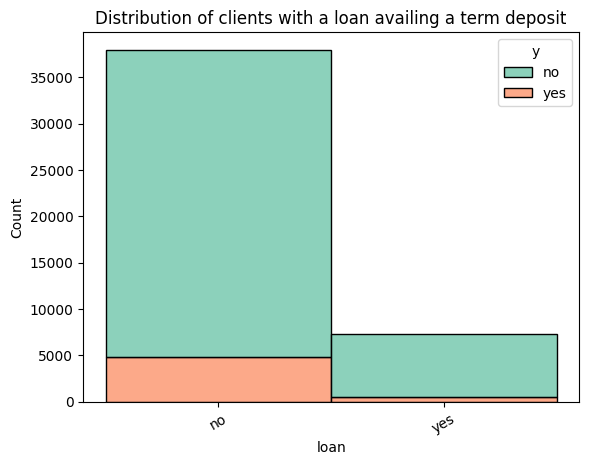

In [12]:
sns.histplot(data=data, x='loan', hue='y', binwidth=0.8, multiple='stack', palette='Set2')
plt.title('Distribution of clients with a loan availing a term deposit')
plt.xticks(rotation=30, fontsize=10)
plt.show()

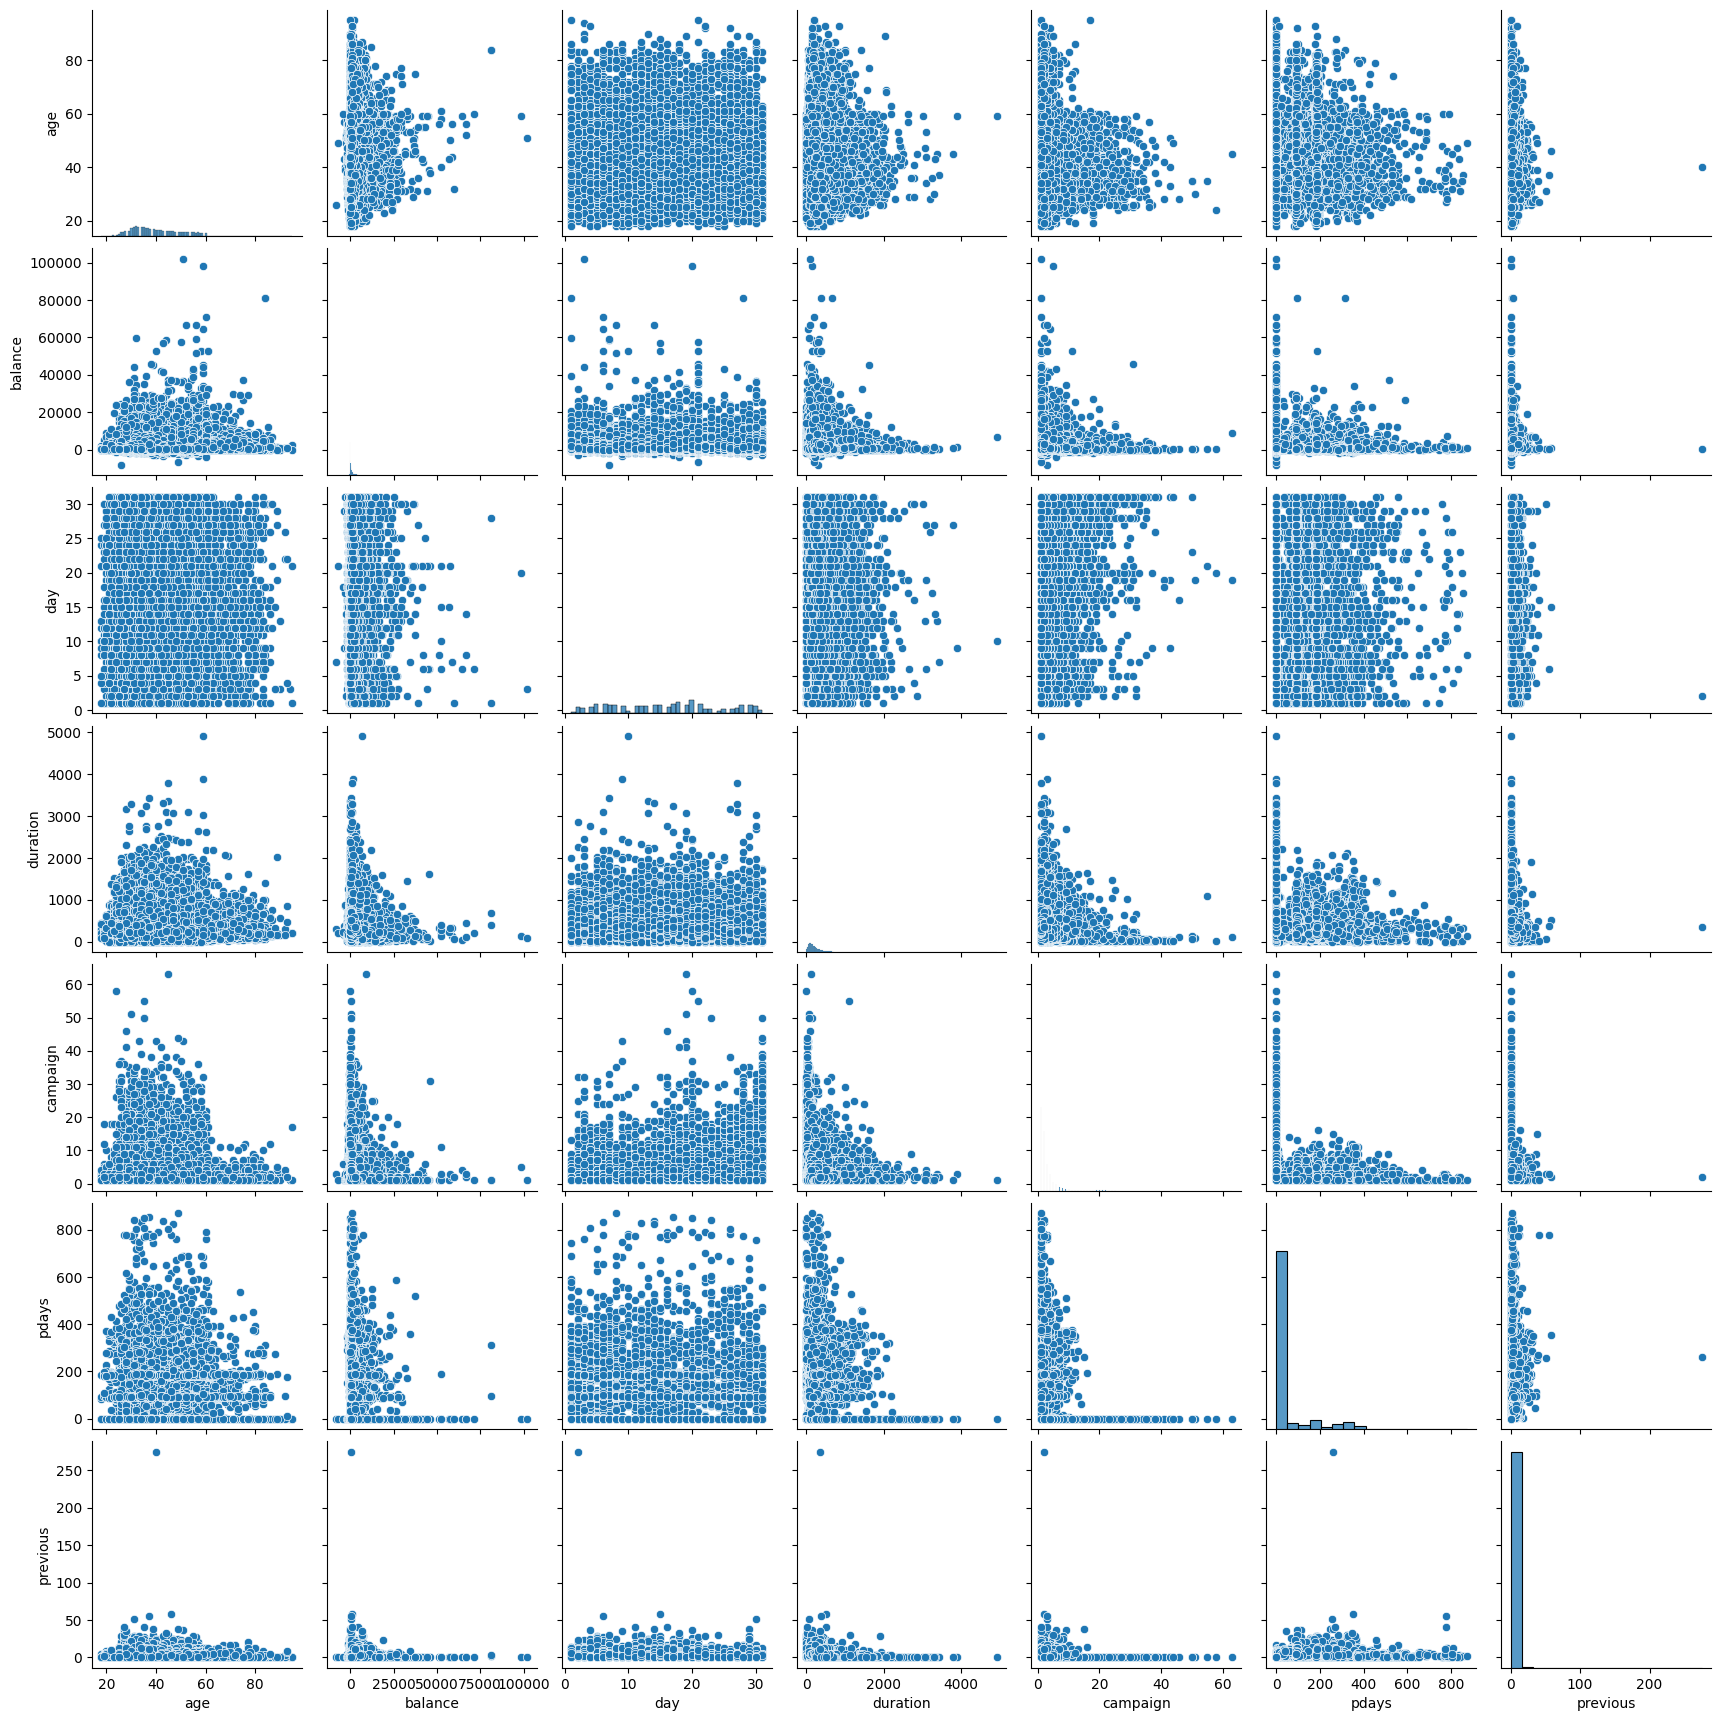

<Figure size 640x480 with 0 Axes>

In [13]:
sns.pairplot(data)
plt.show()
plt.savefig('pairplot.png', dpi=300)

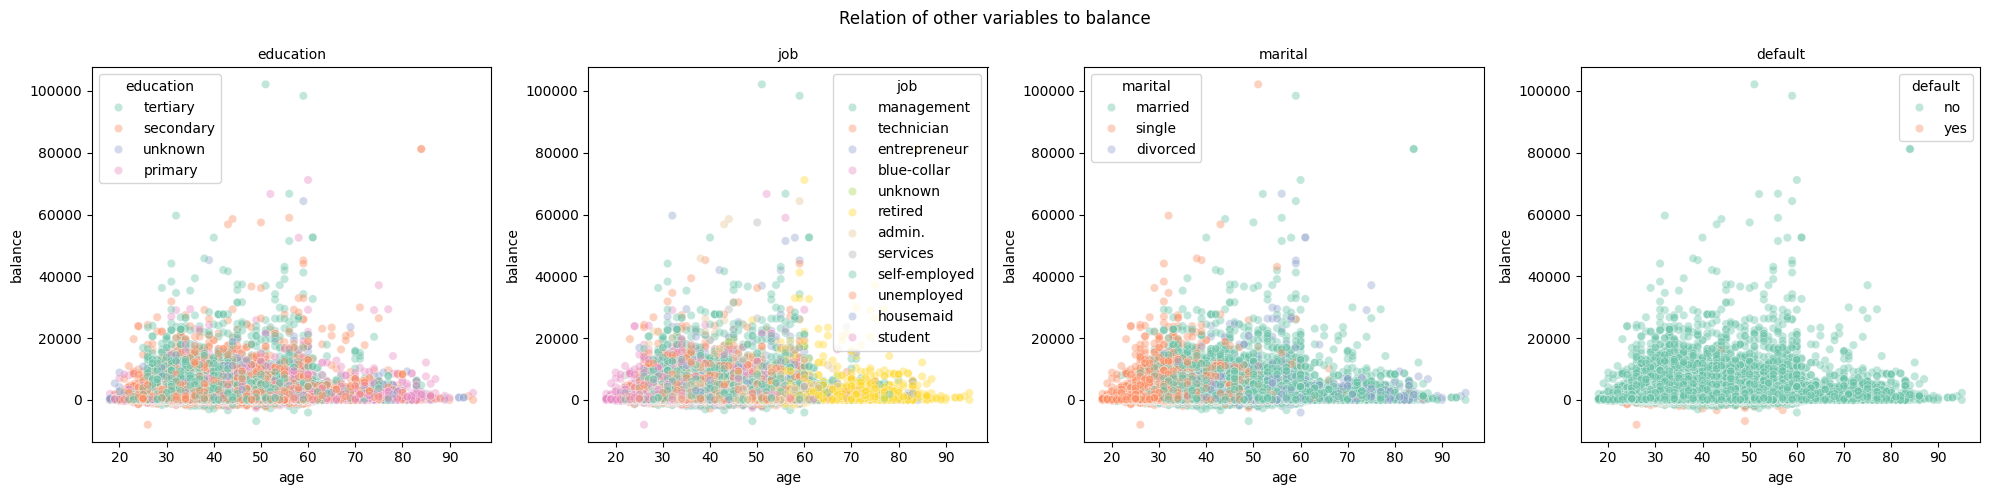

In [14]:
plt.figure(figsize=(20, 5))
plt.suptitle('Relation of other variables to balance')
for idx, var in enumerate(['education', 'job', 'marital', 'default']):
    plt.subplot(1, 4, idx+1)
    sns.scatterplot(data=data, x='age', y='balance', hue=var, alpha=0.4, palette='Set2')
    plt.title(var, fontsize=10)
    sns.color_palette("Set2")
plt.tight_layout()
plt.show()
# plt.savefig('age_balance.png', dpi=300

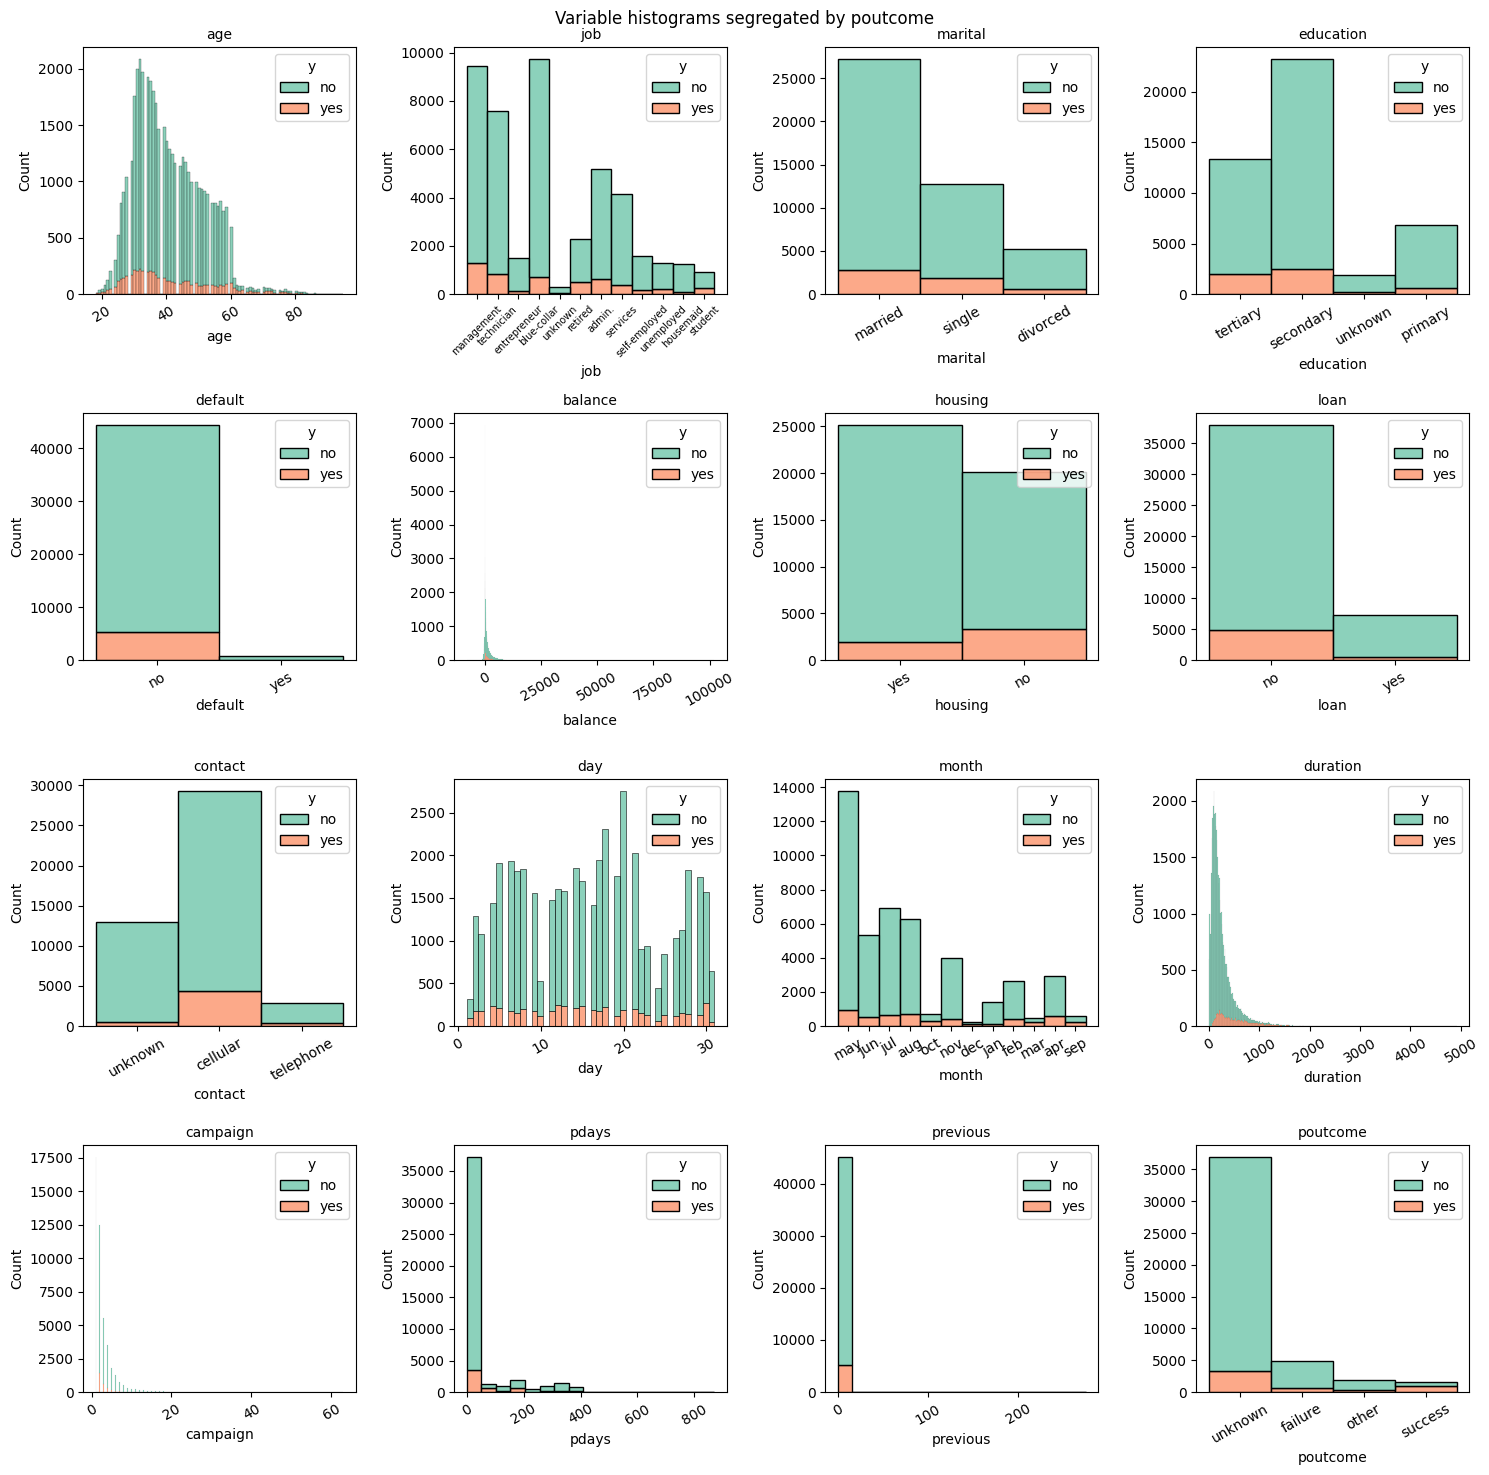

In [15]:
feature_columns = data.columns[:-1]

plt.figure(figsize=(15, 15))
plt.suptitle('Variable histograms segregated by poutcome')
for idx, var in enumerate(feature_columns):
  plt.subplot(4, 4, idx+1)
  sns.histplot(data=data, x=var, hue='y', multiple='stack', palette='Set2')
  plt.title(var, fontsize=10)
  if idx == 1:
    font_size, angle = 7, 45
  else:
    font_size, angle = 10, 30
  plt.xticks(rotation=angle, fontsize=font_size)
plt.tight_layout()
plt.show()

### Preprocessing data

#### Encoding categorical data
Since our data contains categorical and binary variables, we have to convert them into numerical ones so that our ML models could understand them. We have the choice of converting our variables between one-hot encoding and label encoding, however we will choose the former as our variables are not in order (except `month`).

In [16]:
data_target = data['y']
data_features = data.iloc[:, :-1]

In [17]:
num_features = data_features.select_dtypes(include=np.number)
cat_features = data_features.select_dtypes(include=object)

##### **Target**

Let's focus on the target first since that is easy. Our target `y` is just a boolean, so we can convert it easily with a dictionary.

In [18]:
data_target_new = data_target.map({'no':0, 'yes':1})

##### **Numerical features**

From the summary earlier, the `balance` column has a lot of range while the other columns does not possess that same range. This will result in `balance` influencing the algorithm more as it has bigger values. What we should do is to standardize the data so that every feature has equal weight.

In [19]:
scaler = MinMaxScaler()
num_features_new = pd.DataFrame(scaler.fit_transform(num_features), columns=num_features.columns)
num_features_new

,age,balance,day,duration,campaign,pdays,previous
0,0.519481,0.092259,0.133333,0.053070,0.000000,0.000000,0.000000
1,0.337662,0.073067,0.133333,0.030704,0.000000,0.000000,0.000000
2,0.194805,0.072822,0.133333,0.015453,0.000000,0.000000,0.000000
3,0.376623,0.086476,0.133333,0.018707,0.000000,0.000000,0.000000
4,0.194805,0.072812,0.133333,0.040260,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
45206,0.428571,0.080293,0.533333,0.198658,0.032258,0.000000,0.000000
45207,0.688312,0.088501,0.533333,0.092721,0.016129,0.000000,0.000000
45208,0.701299,0.124689,0.533333,0.229158,0.064516,0.212156,0.010909
45209,0.506494,0.078868,0.533333,0.103294,0.048387,0.000000,0.000000


##### **Categorical features**

For the categorical features, we may want to use `data_features.select_dtypes(include=object)` for ease of use, and well yes, but it doesn't aid us when we interpret it. The way the aforementioned code works is it takes all of the unique values in an array, and assign values to all of the unique values.

For the "true" categorical features such as `job`, the labels can be arbitrary, but for the boolean columns and `month`, it can prove to give unexpected results. The value `no` can be labeled as `1` and vice-versa. For `month`, since there is an established order for months, it would help that the months are labeled ordinally.

That is why we will separate the categorical columns into three:
- "true" categories: `job`, `marital`, `education`, `education`, `contact`, `poutcome`
- boolean: `default`, `housing`, `loan`
- ordinal: `month`

In [20]:
cat_features = data_features[['job', 'marital', 'education', 'contact', 'poutcome']]
bool_features = data_features[['default', 'housing', 'loan']]
ordinal_features = data_features['month']

For cat_features, we can encode them using `LabelEncoder()` from `sklearn.preprocessing`.

In [21]:
cat_columns = cat_features.columns
label_encoder = LabelEncoder()
cat_encoded_list = [label_encoder.fit_transform(cat_features[col]) for col in cat_columns]
cat_encoded_df = pd.DataFrame({cat_columns[idx]:cat_encoded_list[idx] for idx, col in enumerate(cat_columns)})
cat_encoded_df

,job,marital,education,contact,poutcome
0,4,1,2,2,3
1,9,2,1,2,3
2,2,1,1,2,3
3,1,1,3,2,3
4,11,2,3,2,3
...,...,...,...,...,...
45206,9,1,2,0,3
45207,5,0,0,0,3
45208,5,1,1,0,2
45209,1,1,1,1,3


For `bool_features`, we can reuse what we did on `data_target`

In [22]:
bool_columns = bool_features.columns
bool_encoded_list = [bool_features[col].map({'no':0, 'yes':1}) for col in bool_columns]
bool_encoded_df = pd.DataFrame({bool_columns[idx]:bool_encoded_list[idx] for idx, col in enumerate(bool_columns)})
bool_encoded_df

,default,housing,loan
0,0,1,0
1,0,1,0
2,0,1,1
3,0,1,0
4,0,0,0
...,...,...,...
45206,0,0,0
45207,0,0,0
45208,0,0,0
45209,0,0,0


Now, we can do the same method for `month` by using a dictionary, but using the function `to_datetime` from Pandas is much easier. Since the months are not spelled out, we must use `format='%b'` as an argument in the function.

In [23]:
month_df = pd.to_datetime(data['month'], format='%b').dt.month
month_df

,month
0,5
1,5
2,5
3,5
4,5
...,...
45206,11
45207,11
45208,11
45209,11


Then, we can concatenate the numerical features `num_features_new` and all of the encoded categorical features `cat_encoded_df`.

In [24]:
data_features_new = pd.concat([num_features_new, cat_encoded_df, bool_encoded_df, month_df], axis=1)
data_features_new

,age,balance,day,duration,campaign,pdays,previous,job,marital,education,contact,poutcome,default,housing,loan,month
0,0.519481,0.092259,0.133333,0.053070,0.000000,0.000000,0.000000,4,1,2,2,3,0,1,0,5
1,0.337662,0.073067,0.133333,0.030704,0.000000,0.000000,0.000000,9,2,1,2,3,0,1,0,5
2,0.194805,0.072822,0.133333,0.015453,0.000000,0.000000,0.000000,2,1,1,2,3,0,1,1,5
3,0.376623,0.086476,0.133333,0.018707,0.000000,0.000000,0.000000,1,1,3,2,3,0,1,0,5
4,0.194805,0.072812,0.133333,0.040260,0.000000,0.000000,0.000000,11,2,3,2,3,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,0.428571,0.080293,0.533333,0.198658,0.032258,0.000000,0.000000,9,1,2,0,3,0,0,0,11
45207,0.688312,0.088501,0.533333,0.092721,0.016129,0.000000,0.000000,5,0,0,0,3,0,0,0,11
45208,0.701299,0.124689,0.533333,0.229158,0.064516,0.212156,0.010909,5,1,1,0,2,0,0,0,11
45209,0.506494,0.078868,0.533333,0.103294,0.048387,0.000000,0.000000,1,1,1,1,3,0,0,0,11


### Feature selection

Now that we have concatenated the numerical and categorical features, we can move on to feature selection. This will ensure that the confounding variables are eliminated, all of the variables are relevant, and no overfitting will occur.

#### Feature correlation

We see if some features are correlated with each other, so that we can remove confounding variables.

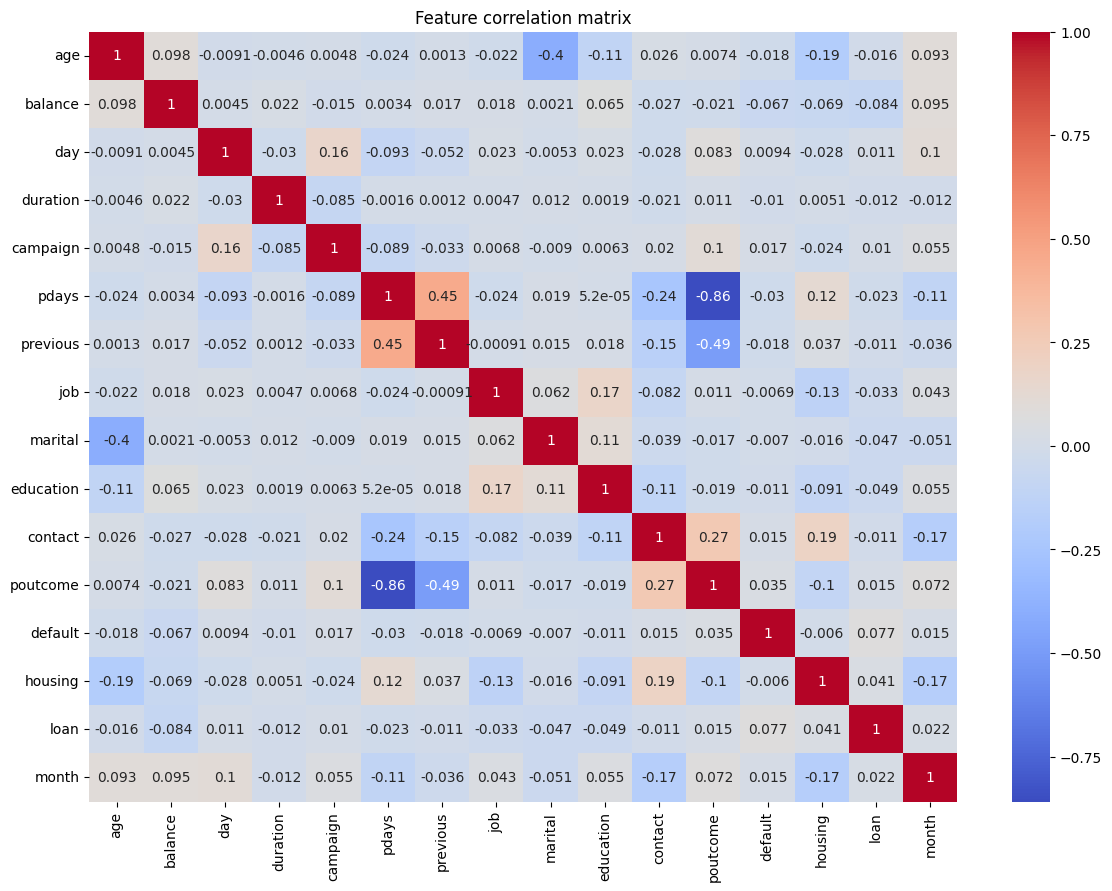

In [25]:
# Plotting the correlation matrix
plt.figure(figsize=(14, 10))
plt.title('Feature correlation matrix')
sns.heatmap(data_features_new.corr(), annot=True, cmap='coolwarm')
plt.show()

What we are looking for here is medium to strong correlation between each feature. Immediately, we three variable pairs that satisfy this:
- `previous` v. `pdays`: 0.58 (medium positive correlation)
- `poutcome` v. `pdays`: -0.86 (strong negative correlation)
- `poutcome` v. `previous`: -0.64 (medium negative correlation)

It makes sense that there is this correlation between the three as they are all controlled by the contact of telesales/sales agent to the customer.

Let's examine the shapes of our features and target to see if they have the same length.

In [26]:
print(data_target_new.shape, data_features_new.shape)

(45211,) (45211, 16)


Now, we must split our data with the usual train-test-val split (60:20:20).

In [27]:
# Splitting data with 70:30 first
x_train, x_test, y_train, y_test = train_test_split(data_features_new, data_target_new, test_size = 0.3, random_state=26)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=26) # 0.25 x 0.8 = 0.2

### Sampling and modeling the data

Since our data features moderate imbalance, as only 13% of the clients surveyed availed a term deposit in both `bank.csv` and `bank-full.csv`, we should either do undersampling, oversampling, or a combination of both. We will also use multiple ML models and rank them via their precision and recall rather than accuracy due to the imbalance in our data.

Lastly, the models that we will use are:
- LogisticRegressor
- RandomForestClassifier
- DecisionTreeClassifier
- GradientBoostingClassifier
- AdaBoostClassifier
- ExtraTreesClassifier
- XGBoostClassifier
- LightGBMClassifier


#### Sampling the data

As aforementioned, we will use various techniques to address the imbalance in our dataset. We will have our un-imputed data as control, oversampling, undersampling, and combined resampling methods.

##### **ML Metrics**

But before that, we will make a function first that will automatically use our ML models and outputs the relevant results: precision, recall, F1 score, and AUC. **Precision** is the percentage of positive predictions that were correct while **recall** is the percentage of actual positive instances that the model identified successfully [1]. **F1 score** is basically a combination of the two as it is determined by taking the harmonic mean of the two. Meanwhile, **AUC** or area under the curve represents the probability that the model will rank the positive higher than the negative if given a positive and negative example [2].

In [28]:
def run_models(x_train, x_val, y_train, y_val, model_dict):
  # Runs a model from model_dict that takes in aalready split data.
  # It outputs a dataframe that contains the precision, recall, f1, auc and runtime of the model.

  # Metrics
  train_scores, val_scores = [], []
  train_precision, val_precision = [], []
  train_recall, val_recall = [], []
  train_f1, val_f1 = [], []
  train_auc, val_auc = [], []
  time_runs = []

  # Preprocessing
  for model_name, model in model_dict.items():
    # Starting stopwatch
    time_start = time.time()

    # Fitting and predicting
    model.fit(x_train, y_train)
    train_pred = model.predict(x_train)
    val_pred = model.predict(x_val)

    # Logging the metrics
    ## Accuracy
    train_scores.append(model.score(x_train, y_train))
    val_scores.append(model.score(x_val, y_val))
    ## Precision
    train_precision.append(precision_score(y_train, train_pred))
    val_precision.append(precision_score(y_val, val_pred))
    ## Recall
    train_recall.append(recall_score(y_train, train_pred))
    val_recall.append(recall_score(y_val, val_pred))
    ## F1 score
    train_f1.append(f1_score(y_train, train_pred))
    val_f1.append(f1_score(y_val, val_pred))
    ## AUC
    train_auc.append(roc_auc_score(y_train, train_pred))
    val_auc.append(roc_auc_score(y_val, val_pred))

    # Ending stopwatch
    time_end = time.time()
    time_run = time_end - time_start
    time_runs.append(time_run)

  # Collating results
  result_df = pd.DataFrame(
      {'Model': list(models_dict.keys()),
       'Train accuracy': train_scores, 'Validation accuracy': val_scores,
       'Train precision': train_precision, 'Validation precision': val_precision,
       'Train recall': train_recall, 'Validation recall': val_recall,
       'Train F1': train_f1, 'Validation F1': val_f1,
       'Train AUC': train_auc, 'Validation AUC': val_auc,
       'Runtime': time_runs
       }
  )
  return result_df

In [29]:
models_dict = {
    'LogisticRegressor': LogisticRegression(),
    'RandomForestClassifier': RandomForestClassifier(random_state=26, max_features=None),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=26),
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state=26),
    'SVC': SVC(random_state=26),
    'AdaBoostClassifier': AdaBoostClassifier(random_state=26),
    'ExtraTreesClassifier': ExtraTreesClassifier(random_state=26),
    'XGBoostClassifier': XGBClassifier(random_state=26, use_label_encoder=False, eval_metric='logloss'),
    'LightGBMClassifier': lgb.LGBMClassifier(random_state=26, verbosity=-1)
}

##### **Control sample**

The control sample will use the computed train, validation, and test split earlier. Now, we can finally run all of these models on our control data.

In [30]:
results_control = run_models(x_train, x_val, y_train, y_val, models_dict)
results_control

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. 

,Model,Train accuracy,Validation accuracy,Train precision,Validation precision,Train recall,Validation recall,Train F1,Validation F1,Train AUC,Validation AUC,Runtime
0,LogisticRegressor,0.891974,0.890293,0.609355,0.649402,0.176105,0.172853,0.273243,0.273032,0.580695,0.580113,0.219373
1,RandomForestClassifier,1.000000,0.903817,1.000000,0.630000,1.000000,0.467656,1.000000,0.536823,1.000000,0.715246,13.960107
2,DecisionTreeClassifier,1.000000,0.874747,1.000000,0.475410,1.000000,0.492047,1.000000,0.483585,1.000000,0.709289,0.200514
3,GradientBoostingClassifier,0.913503,0.904702,0.713750,0.674677,0.417245,0.387063,0.526631,0.491914,0.697717,0.680904,4.833929
4,SVC,0.884685,0.880814,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000,39.869872
5,AdaBoostClassifier,0.895302,0.893579,0.593472,0.611973,0.292291,0.292683,0.391677,0.395983,0.633097,0.633786,1.586499
6,ExtraTreesClassifier,1.000000,0.901542,1.000000,0.673729,1.000000,0.337222,1.000000,0.449470,1.000000,0.657562,3.464043
7,XGBoostClassifier,0.968233,0.906977,0.929035,0.643950,0.784436,0.490986,0.850634,0.557160,0.888313,0.727126,0.556777
8,LightGBMClassifier,0.939541,0.907230,0.813282,0.650794,0.617464,0.478261,0.701973,0.551345,0.799493,0.721768,0.849569


To easily visualize the precision and recall scores for most of the models, we can plot the results below. We will not conside the `accuracy` scores as that doesn't punish the the model for making wrong predictions.

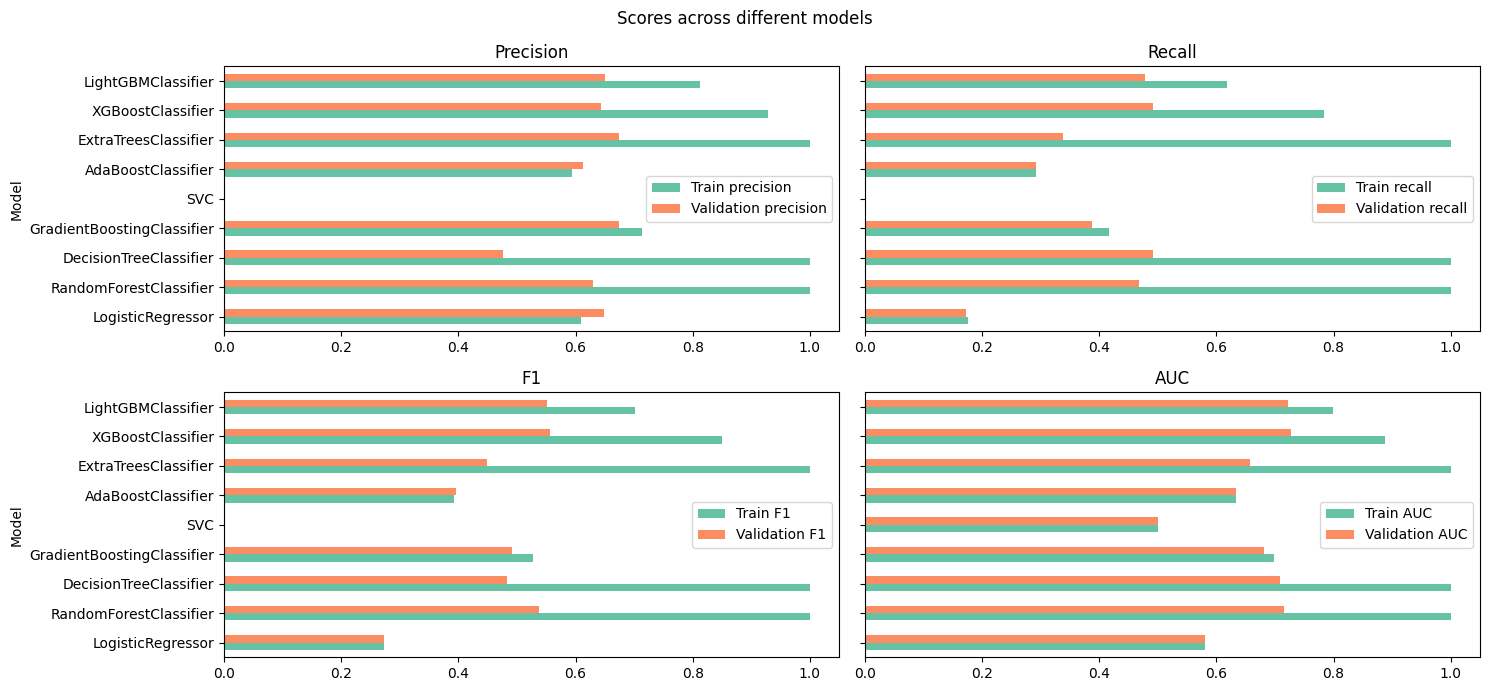

In [31]:
metrics_pair = np.array(results_control.columns[3:-1]).reshape((4, 2))
titles = ['Precision', 'Recall', 'F1', 'AUC']
colors = sns.color_palette("Set2", as_cmap=True)(np.linspace(0, 1, 6))

fig, axes = plt.subplots(2, 2, figsize=(15, 7))
plt.suptitle('Scores across different models')
for idx, pair in enumerate(metrics_pair):
  # Reshape data for horizontal plotting
  plot_data_control = results_control[np.concatenate((['Model'], pair), axis=0)]
  plot_data_control = plot_data_control.set_index('Model')

  # Create horizontal bar chart
  i, j = idx // 2, idx % 2
  ax = axes[i, j]
  ax.set_xlabel('Score')
  ax.set_title(f'{titles[idx]}')
  plot_data_control.plot(ax=ax, kind='barh', color=colors)

  # Remove ylabels except 1st subplot
  if idx == 1 or idx == 3:
        ax.set_yticklabels([])
        ax.set_ylabel('')

plt.tight_layout()
plt.show()

As we can see above, we can see that the scores in training always perform better than that in validation as the model hasn't seen the data in validation yet. We can also observe that SVC is a terrible model as it produced 0% recall and precision while having ~88% accuracy. This is another example why we cannot trust accuracy as a metric.

The top 3 performing models for each validation score are as follows:
- Precision: GradientBoosting > ExtraTrees > LightGBM
- Recall: DecisionTree > XGB > LightGBM
- F1 score: XGB > LightGBM > RandomForest
- AUC score: LightGBM > XGB > RFC

We can see that LightGBM made the cut for top 3 in all of the scores while XGB made it in the latter 3 (as XGB was only top 4 in precision). By this demonstration we can see then that **F1 score is the score that we need to watch out for** in every model as it manages to balance out precision, recall, and AUC.

##### **Undersampling**

Now, we will consider undersampling. Since our data contains 5289 rows with `y` values as `yes`, this algorithm will also cut the rows with `no` as a `y` value to 5289.

In [42]:
undersampling_dict = {'RandomUnderSampler': RandomUnderSampler(random_state=26),
                      'TomekLinks': TomekLinks(),
                      'NearMiss': NearMiss(),
                      'AllKNN': AllKNN(),
                      'ENN': EditedNearestNeighbours(),
                      'RepeatedENN': RepeatedEditedNearestNeighbours()}

In [44]:
results_undersampler = []

# Running run_models on each undersampler
for sampler_name, sampler in undersampling_dict.items():
  x_train_resampled, y_train_resampled = sampler.fit_resample(x_train, y_train)
  results_undersampler.append(run_models(x_train_resampled, x_val, y_train_resampled, y_val, models_dict))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:53:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-

In [60]:
# Initialize the dataframe that will house F1 scores across different models and undersamplers
results_f1_undersample = pd.DataFrame({'Model': models_dict.keys(), 'Control':results_control['Validation F1']})

# Plotting
dict_undersample = {}
for idx, result in enumerate(results_undersampler):
  dict_temp = {list(undersampling_dict.keys())[idx]: result['Validation F1']}
  dict_undersample.update(dict_temp)

results_f1_undersample = pd.concat([results_f1_undersample, pd.DataFrame(dict_undersample)], axis=1)
results_f1_undersample

,Model,Control,RandomUnderSampler,TomekLinks,NearMiss,AllKNN,ENN,RepeatedENN
0,LogisticRegressor,0.273032,0.476796,0.299674,0.333876,0.387143,0.383103,0.397759
1,RandomForestClassifier,0.536823,0.552024,0.573059,0.362808,0.621810,0.616867,0.623963
2,DecisionTreeClassifier,0.483585,0.461442,0.517695,0.324192,0.542921,0.531934,0.539966
3,GradientBoostingClassifier,0.491914,0.551538,0.526115,0.392157,0.596766,0.590836,0.602129
4,SVC,0.000000,0.357229,0.000000,0.257485,0.109023,0.026860,0.182609
5,AdaBoostClassifier,0.395983,0.509690,0.442034,0.399799,0.507375,0.485340,0.502208
6,ExtraTreesClassifier,0.449470,0.546912,0.499339,0.292210,0.584044,0.567901,0.590887
7,XGBoostClassifier,0.557160,0.587318,0.587699,0.366173,0.628248,0.627986,0.627433
8,LightGBMClassifier,0.551345,0.592883,0.582047,0.381905,0.639849,0.638091,0.634921


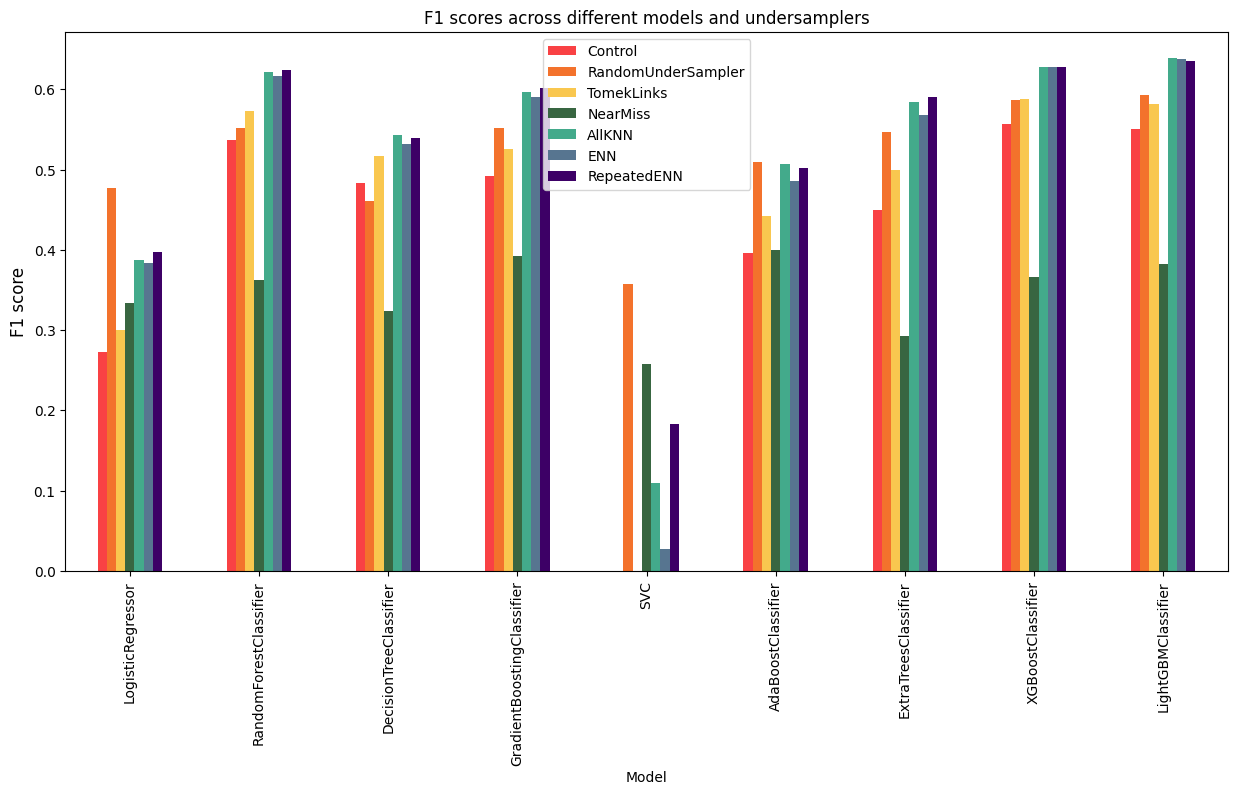

In [76]:
colors_new = ['#f94144', '#f3722c', '#f9c74f', '#386641', '#43aa8b', '#577590', '#3d0066']
cmap_new = cm.LinearSegmentedColormap.from_list("cmap_undersample", colors_new)
model_names = list(models_dict.keys())

# Plotting
fig, ax = plt.subplots(figsize=(15, 7))
ax.set_title('F1 scores across different models and undersamplers')
ax.set_ylabel('F1 score', fontsize = 12)
results_f1_undersample.plot(ax=ax, kind='bar', color=colors_new)
ax.set_xticklabels(model_names, rotation=90, fontsize=10)
ax.set_xlabel('Model')
plt.show()

##### **Oversampling and combined methods**

For oversampling, the algorithm will try to inflate the minority group by either duplicating the minority or creating new minority values by interpolation. These are `RandomOverSampler`, `SMOTE`, `ADASYN`, and `BorderlineSMOTE`.
Combined methods is, exactly what you think, combining undersampling and oversampling methods.


In [51]:
oversampling_dict = {'RandomOverSampler': RandomOverSampler(random_state=26),
                    'SMOTE': SMOTE(random_state=26),
                    'ADASYN': ADASYN(random_state=26),
                    'BorderlineSMOTE': BorderlineSMOTE(random_state=26),
                    'SMOTEENN': SMOTEENN(random_state=26),
                    'SMOTETomek': SMOTETomek(random_state=26)}

In [53]:
results_oversampler = []

# Running run_models on each undersampler
for sampler_name, sampler in oversampling_dict.items():
  x_train_resampled, y_train_resampled = sampler.fit_resample(x_train, y_train)
  results_oversampler.append(run_models(x_train_resampled, x_val, y_train_resampled, y_val, models_dict))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:05:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-

In [61]:
# Initialize the dataframe that will house F1 scores across different models and undersamplers
results_f1_oversample = pd.DataFrame({'Model': models_dict.keys(), 'Control':results_control['Validation F1']})

# Plotting
dict_oversample = {}
for idx, result in enumerate(results_oversampler):
  dict_temp = {list(oversampling_dict.keys())[idx]: result['Validation F1']}
  dict_oversample.update(dict_temp)

results_f1_oversample = pd.concat([results_f1_oversample, pd.DataFrame(dict_oversample)], axis=1)
results_f1_oversample

,Model,Control,RandomOverSampler,SMOTE,ADASYN,BorderlineSMOTE,SMOTEENN,SMOTETomek
0,LogisticRegressor,0.273032,0.489635,0.498624,0.495938,0.491144,0.459756,0.499484
1,RandomForestClassifier,0.536823,0.558315,0.575758,0.563303,0.582543,0.593904,0.573786
2,DecisionTreeClassifier,0.483585,0.449561,0.495591,0.461740,0.485964,0.533009,0.502238
3,GradientBoostingClassifier,0.491914,0.561428,0.585323,0.578970,0.595135,0.585291,0.588941
4,SVC,0.000000,0.516329,0.512496,0.505256,0.496071,0.479391,0.512839
5,AdaBoostClassifier,0.395983,0.502130,0.517629,0.491279,0.516154,0.516992,0.516811
6,ExtraTreesClassifier,0.449470,0.405926,0.575553,0.589227,0.585193,0.582524,0.589251
7,XGBoostClassifier,0.557160,0.611395,0.597541,0.596697,0.595970,0.623012,0.589056
8,LightGBMClassifier,0.551345,0.609674,0.601912,0.614848,0.614553,0.621812,0.602301


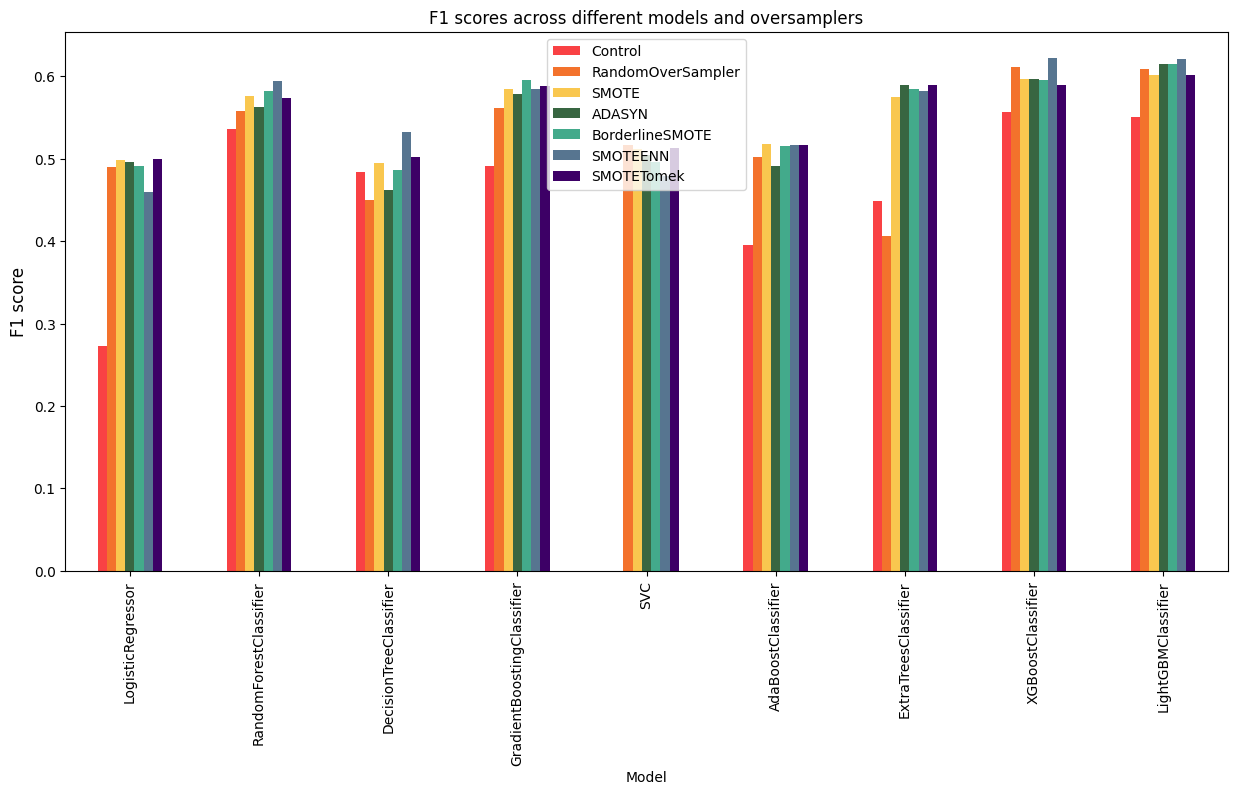

In [79]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.set_title('F1 scores across different models and oversamplers')
ax.set_ylabel('F1 score', fontsize = 12)

# Plotting
results_f1_oversample.plot(ax=ax, kind='bar', color=colors_new)
ax.set_xticklabels(model_names, rotation=90, fontsize=10)
ax.set_xlabel('Model')
plt.show()

#### SHAP values

[SHAP values](https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137/) or (Shapley Additive Explanations) is a method based on game theory and is mainly used for easier interpretation of machine learning models. We will use this method to provide more context to the results of our model.

In [36]:
explainer_rfc = shap.Explainer(rfc)
shapval_rfc = explainer_rfc(x_train[0:100])

NameError: name 'rfc' is not defined

In [ ]:
shapval_rfc.shape

`shapval_rfc` is an Explanation object with shape $n\times16\times2$. We can use a waterfall plot to try to explain how each variable was taken into account in the model, how impactful they are and how they influence the prediction of the class of a datapoint.

Below, we have the waterfall plot of the first sample, and how the variables

In [ ]:
shapval_rfc[0]

In [ ]:
shap.plots.waterfall(shapval_rfc[0, :, 0]) # First sample, first class

In [ ]:
shap.plots.waterfall(shapval_rfc[0, :, 1]) # First sample, second class

### Sources cited

[1] https://encord.com/blog/classification-metrics-accuracy-precision-recall
[2] https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc